<a href="https://www.kaggle.com/ishaniarya/ishani-arya-ds?scriptVersionId=90290025" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [35]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv
/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip
/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip


In [36]:
#importing rapids libraries
import cudf
import cupy

#importing important libraries
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from bs4 import BeautifulSoup
import re
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
import random
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense,Dropout,Embedding,LSTM
from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy

from keras.models import Sequential


In [37]:
#importing csv file of the given data 
train=pd.read_csv('/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip',sep='\t')
test=pd.read_csv('/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip',sep='\t')

**Understanding the given dataset**

The next few steps will help us understand the data in terms of shape, description, etc such that it is easier to work on its preprocessing.

In [38]:
print(train.shape,test.shape)
train.head(10)

(156060, 4) (66292, 3)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


The sentiment labels are:

0 - negative

1 - somewhat negative

2 - neutral

3 - somewhat positive

4 - positive

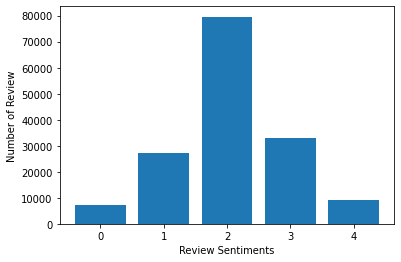

In [39]:
Sentiment_count=train.groupby('Sentiment').count()
plt.bar(Sentiment_count.index.values, Sentiment_count['Phrase'])
plt.xlabel('Review Sentiments')
plt.ylabel('Number of Review')
plt.show()

In [24]:
train.Sentiment.value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

In [25]:
train.isnull().any().any()


False

In [26]:
test.isnull().any().any()

False

**Data Preprocessing**

This stage will be used to clean the data by removing html tags, non-alphabetic characters, etc and make the data

a. consistent and efficient

b. easier for the learning algorithm to parse

In [40]:
#Function for cleaning the reviews, tokenize and lemmatize them.

def clean_sentences(df):
    reviews = []

    for sent in tqdm(df['Phrase']):
        
        #remove html content
        review_text = BeautifulSoup(sent).get_text()
        
        #remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
        
    
        #tokenize the sentences
        words = word_tokenize(review_text.lower())
    
        #lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
    
        reviews.append(lemma_words)

    return(reviews)

In [41]:
#retrieving cleaned reviews for both train and test set 

train_sentences = clean_sentences(train)
test_sentences = clean_sentences(test)

print(len(train_sentences))
print(len(test_sentences))

  0%|          | 0/156060 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:343: MarkupResemblesLocatorWarning: "." looks like a directory name, not markup. You may want to open a file found in this directory and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning
100%|██████████| 66292/66292 [00:29<00:00, 2265.54it/s]

156060
66292


In [42]:
#Collect the dependent values and convert to one-hot encoded output using to_categorical

target=train.Sentiment.values
y_target=to_categorical(target)
num_classes=y_target.shape[1]

In [43]:
X_train,X_val,y_train,y_val = train_test_split(train_sentences,y_target,
                                             test_size=0.2,stratify=y_target)

In [44]:
#Geting the No. of unique words and max length of a review available in the list of cleaned reviews.

unique_words = set()
len_max = 0

for sent in tqdm(X_train):
    
    unique_words.update(sent)
    
    if(len_max<len(sent)):
        len_max = len(sent)
        
print(len(list(unique_words)))
print(len_max)

100%|██████████| 124848/124848 [00:00<00:00, 573669.26it/s]

13733
48


In [45]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(X_train))

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(test_sentences)


X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_val = sequence.pad_sequences(X_val, maxlen=len_max)
X_test = sequence.pad_sequences(X_test, maxlen=len_max)

print(X_train.shape,X_val.shape,X_test.shape)

(124848, 48) (31212, 48) (66292, 48)


In [46]:
early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_acc', patience = 2)
callback = [early_stopping]

In [47]:
#Model using Keras LSTM

model=Sequential()

model.add(Embedding(len(list(unique_words)),300,input_length=len_max))
model.add(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy','mean_squared_error'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 48, 300)           4119900   
_________________________________________________________________
lstm_2 (LSTM)                (None, 48, 128)           219648    
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               6500      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 505       
Total params: 4,395,961
Trainable params: 4,395,961
Non-trainable params: 0
____________________________________________

In [48]:
history=model.fit(X_train, y_train, validation_data=(X_val, y_val),
                  epochs=6, batch_size=256, verbose=1, callbacks=callback)

Epoch 1/6
488/488 [==============================] - 223s 448ms/step - loss: 1.0687 - accuracy: 0.5763 - mean_squared_error: 0.1119 - val_loss: 0.8839 - val_accuracy: 0.6377 - val_mean_squared_error: 0.0967
Epoch 2/6
488/488 [==============================] - 215s 440ms/step - loss: 0.8352 - accuracy: 0.6616 - mean_squared_error: 0.0917 - val_loss: 0.8244 - val_accuracy: 0.6597 - val_mean_squared_error: 0.0918
Epoch 3/6
488/488 [==============================] - 217s 445ms/step - loss: 0.7677 - accuracy: 0.6885 - mean_squared_error: 0.0854 - val_loss: 0.8147 - val_accuracy: 0.6660 - val_mean_squared_error: 0.0906
Epoch 4/6
488/488 [==============================] - 216s 442ms/step - loss: 0.7238 - accuracy: 0.7022 - mean_squared_error: 0.0815 - val_loss: 0.8127 - val_accuracy: 0.6697 - val_mean_squared_error: 0.0904
Epoch 5/6
488/488 [==============================] - 215s 441ms/step - loss: 0.6889 - accuracy: 0.7140 - mean_squared_error: 0.0782 - val_loss: 0.8170 - val_accuracy: 0.671

In [63]:
#model using cnn
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
tokenize = Tokenizer()
embedding_dimension = 100
input_val = len(tokenize.word_index)+1
model_CNN = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(list(unique_words)),300,input_length=len_max),
    tf.keras.layers.Conv1D(128, 2, padding='same',activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 2, padding='same',activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 48, 300)           4119900   
_________________________________________________________________
lstm_2 (LSTM)                (None, 48, 128)           219648    
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               6500      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 505       
Total params: 4,395,961
Trainable params: 4,395,961
Non-trainable params: 0
____________________________________________

In [68]:
model_CNN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history=model.fit(X_train, y_train, validation_data=(X_val, y_val),
                  epochs=6, batch_size=256, verbose=1, callbacks=callback)

Epoch 1/6
488/488 [==============================] - 255s 447ms/step - loss: 0.6366 - accuracy: 0.7332 - mean_squared_error: 0.0732 - val_loss: 0.8426 - val_accuracy: 0.6724 - val_mean_squared_error: 0.0908
Epoch 2/6
488/488 [==============================] - 223s 456ms/step - loss: 0.6159 - accuracy: 0.7403 - mean_squared_error: 0.0712 - val_loss: 0.8588 - val_accuracy: 0.6715 - val_mean_squared_error: 0.0912
Epoch 3/6
488/488 [==============================] - 222s 454ms/step - loss: 0.5983 - accuracy: 0.7460 - mean_squared_error: 0.0695 - val_loss: 0.8779 - val_accuracy: 0.6694 - val_mean_squared_error: 0.0928
Epoch 4/6
488/488 [==============================] - 219s 450ms/step - loss: 0.5818 - accuracy: 0.7511 - mean_squared_error: 0.0679 - val_loss: 0.8976 - val_accuracy: 0.6691 - val_mean_squared_error: 0.0925
Epoch 5/6
488/488 [==============================] - 218s 446ms/step - loss: 0.5654 - accuracy: 0.7565 - mean_squared_error: 0.0663 - val_loss: 0.9349 - val_accuracy: 0.669

Therefore, we can clearly see that the accuracy in CNN model is more(76.15%) than in the lstm model(72.45%).